<a href="https://colab.research.google.com/github/Pravallika-02-datascience/Customer-Feedback-Sentiment-Analysis-NLP-/blob/main/Sentiment_Analysis_final_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  **NLP Sentiment Analysis:**
---

🔧 **Import Required Libraries & Loading data set from <img src="https://ssl.gstatic.com/images/branding/product/2x/drive_2020q4_48dp.png" width="35"/> Gdrive :**

In [ ]:
# Basic Libraries, Visualization Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Warnings
import warnings
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# Then you can use:
import pandas as pd

file_path = '/content/drive/MyDrive/CSV files/dataset.xlsx'               # Update this based on your file requirement
# Load the entire Excel file
excel_file = pd.ExcelFile(file_path)

# See the names of all sheets
print("Sheet names:", excel_file.sheet_names)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Sheet names: ['Sheet1']


In [ ]:
# Load the 'Data' sheet
data = pd.read_excel(excel_file, sheet_name='Sheet1')
df = pd.read_excel(file_path, sheet_name=0) #or sheet_name= 0/1/2...

In [ ]:
df.head()

**This is how our first 5 rows of data look like.**

---
##**Task 1:** 🧐 Exploratory Data Analysis (EDA):
**🔍 Data Exploration, 🧹 Data Cleaning**

In [ ]:
df.shape

(1440, 3)

Our dataset contains **3** **features** and **1440** **records**.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1440 entries, 0 to 1439
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   title   1440 non-null   object
 1   rating  1440 non-null   int64 
 2   body    1440 non-null   object
dtypes: int64(1), object(2)
memory usage: 33.9+ KB


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rating,1440.0,3.173611,1.584453,1.0,1.0,4.0,5.0,5.0


---
## **Map rating to sentiment :**

In [ ]:
def rating_to_sentiment(rating):
    """Convert numerical rating to sentiment label"""
    if pd.isna(rating):
        return "Unknown"
    if rating in [1, 2]:
        return "Negative"
    elif rating == 3:
        return "Neutral"
    elif rating in [4, 5]:
        return "Positive"
    else:
        return "Unknown"  # Handle unexpected values

# Apply sentiment mapping
df['sentiment'] = df['rating'].apply(rating_to_sentiment)

In [ ]:
#Creating a new column 'review_length' that will contain the length of the string

df['review_length'] = df['body'].apply(len)

In [ ]:
df.head()

---
### **[1] *Analyzing 'Sentiment' Column***

The 'Sentiment' column is newly generated, converting numeric ratings into categorical sentiment labels.

In [ ]:
# Get sentiment counts and percentages
#Finding the percentage distribution of each sentiment - we'll divide the number of records for each sentiment by the total number of records

sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = round((sentiment_counts / df.shape[0]) * 100, 2)

# Combine into a single DataFrame for better readability
sentiment_summary = pd.DataFrame({
    'Count': sentiment_counts,
    'Percentage (%)': sentiment_percentages
})

# Display result
print("Sentiment Value Counts and their Percentage Distribution:\n")
sentiment_summary

Sentiment Value Counts and their Percentage Distribution:



,Count,Percentage (%)
sentiment,,
Positive,729,50.62
Negative,512,35.56
Neutral,199,13.82


In [ ]:
# Get sentiment counts and percentages  (if not already done)
sentiment_counts = df['sentiment'].value_counts()
sentiment_percentages = sentiment_counts / sentiment_counts.sum() * 100

# Define explode values — explode slices < 15% (you can adjust this threshold)
explode = [0.05 if pct < 15 else 0 for pct in sentiment_percentages]
colors = sns.color_palette('Paired')

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)

plt.title('Sentiment Pie Distribution')
plt.axis('equal')  # Makes the pie chart a circle
plt.show()


In [ ]:
import plotly.graph_objects as go

# Step 1: Prepare data
temp = df['sentiment'].value_counts().reset_index()
temp.columns = ['sentiment', 'count']

# Step 2: Plot Funnel Area chart
fig = go.Figure(go.Funnelarea(
    text=temp['sentiment'],
    values=temp['count'],
    title={"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))
fig.show()


---
### **[2] *Analyzing 'Rating' Column***

This column refers to the rating given by the user

In [ ]:
df.rating.unique()

array([1, 3, 4, 5, 2])

In [ ]:
#Distinct values of 'rating' and its count
print(df['rating'].value_counts())

rating
5    419
1    386
4    310
3    199
2    126
Name: count, dtype: int64


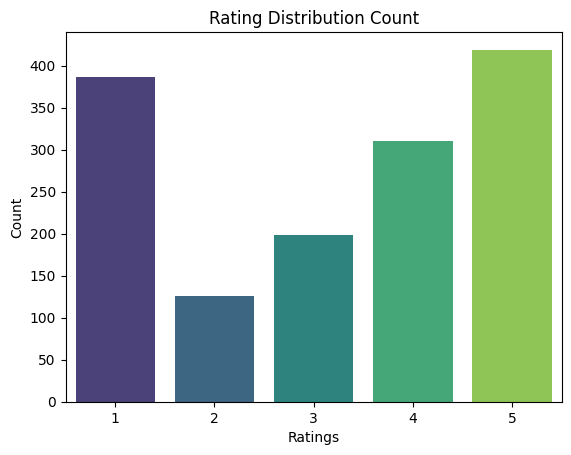

In [ ]:
# Count the ratings
rating_counts = df['rating'].value_counts().sort_index()

palette = sns.color_palette("viridis", n_colors=len(rating_counts))

# Create barplot
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette=palette)

# Labels and title
plt.title('Rating Distribution Count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()


---
### **[3] *Analyzing 'review_length' Column***

In [ ]:
# df['review_length'].describe().T (this will not work on single column so use below 2 any 1 of)
# df['review_length'].describe().to_frame().T
df[['review_length']].describe().T

,count,mean,std,min,25%,50%,75%,max
review_length,1440.0,302.109028,225.733052,4.0,170.0,246.0,359.0,2490.0


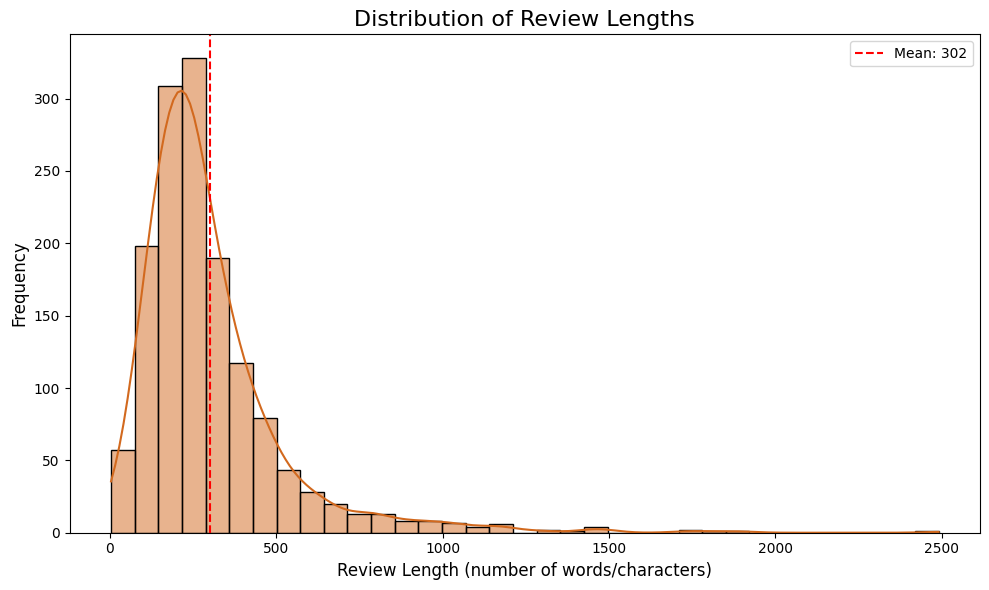

In [ ]:
# Create the histogram with more control and enhancements
plt.figure(figsize=(10, 6))
sns.histplot(
    df['review_length'],
    color='chocolate',
    kde=True,                 # Add KDE (smoothed curve)
    bins=35,                  # Adjust number of bins
    edgecolor='black'         # Make bars clearer
)

# Add titles and labels
plt.title('Distribution of Review Lengths', fontsize=16)
plt.xlabel('Review Length (number of words/characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

avg_length = df['review_length'].mean()
plt.axvline(avg_length, color='red', linestyle='--', label=f'Mean: {avg_length:.0f}')
plt.legend()

plt.tight_layout()
plt.show()


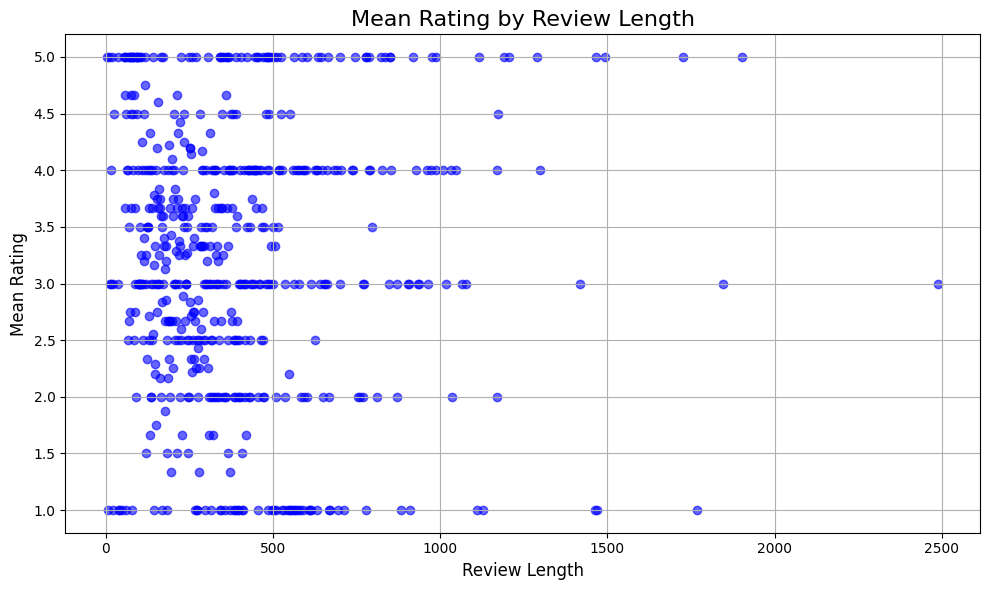

In [ ]:
# Group by review length and calculate mean rating
review_length_mean_rating = df.groupby('review_length')['rating'].mean()

# plot
plt.figure(figsize=(10, 6))
plt.scatter(review_length_mean_rating.index, review_length_mean_rating.values, color='blue', alpha=0.6)
plt.title('Mean Rating by Review Length', fontsize=16)
plt.xlabel('Review Length', fontsize=12)
plt.ylabel('Mean Rating', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


**Key Observations:**

* Most reviews are between **170 to 359** characters/words.
* A few reviews are very long (up to 2490), which may be **outliers**.
* The distribution is **right-skewed** due to long-tail (high max).

---

### **Bin the Review Length** for Better Visualization

Instead of plotting raw `review_length` values (which creates clutter), we’ll group them into **bins or ranges**, like:

* `Short` (0–150)
* `Medium` (151–300)
* `Long` (301–500)
* `Very Long` (500+)

Then plot the **average rating per bin** — this gives meaningful insight and avoids clutter.

---


### 1. 📦 Create Review Length Bins

In [ ]:
import pandas as pd

# Define bins and labels
bins = [0, 150, 300, 500, df['review_length'].max()]
labels = ['Short', 'Medium', 'Long', 'Very Long']

# Create a new column for length category
df['length_category'] = pd.cut(df['review_length'], bins=bins, labels=labels, include_lowest=True)


#### 2. 📈 Plot Mean Rating by Length Category

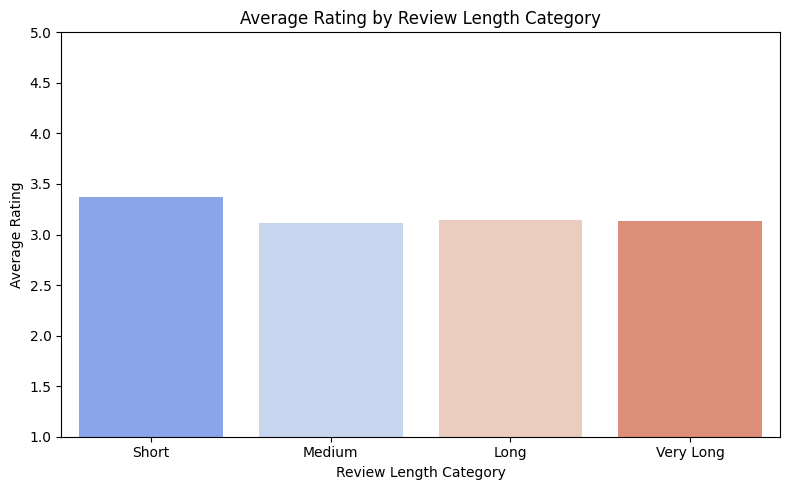

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by the new category
length_rating_summary = df.groupby('length_category')['rating'].mean().reset_index()

# Bar plot
plt.figure(figsize=(8, 5))
sns.barplot(x='length_category', y='rating', data=length_rating_summary, palette='coolwarm')
plt.title('Average Rating by Review Length Category')
plt.xlabel('Review Length Category')
plt.ylabel('Average Rating')
plt.ylim(1, 5)
plt.tight_layout()
plt.show()


#### 🧠 Bonus Insight Options:

* **Countplot** to show how many reviews fall into each length bin:

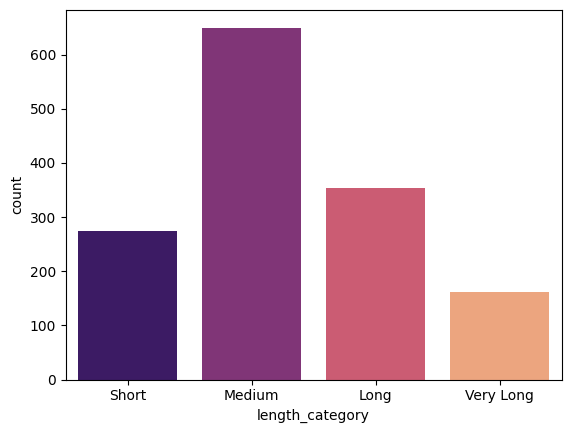

In [ ]:
sns.countplot(x='length_category', data=df, palette='magma')
plt.show()

---
### **A) WordCloud**

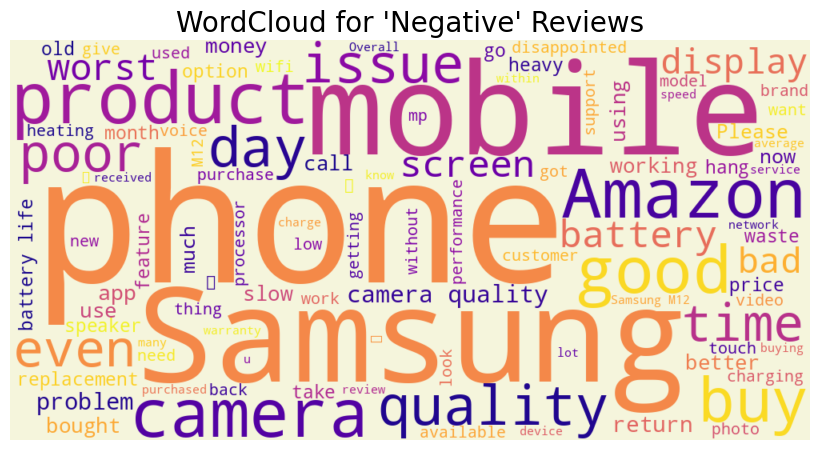

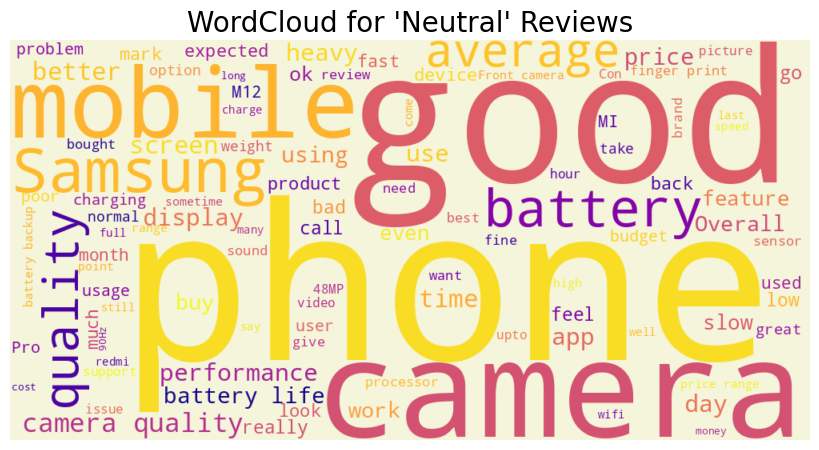

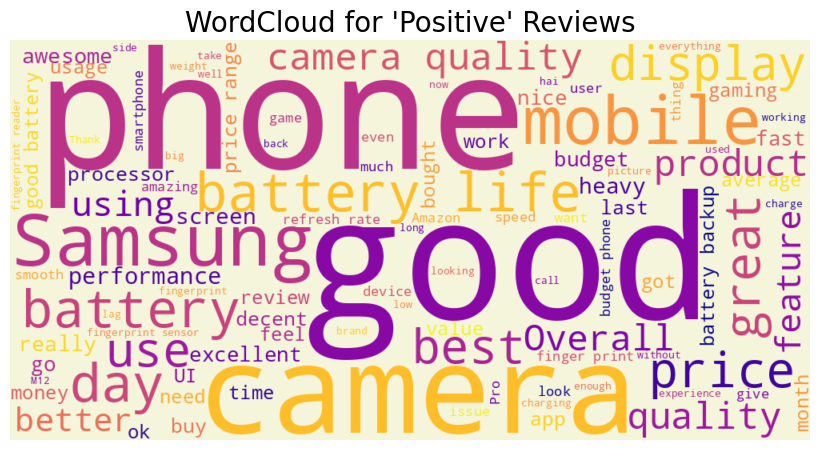

In [ ]:
from wordcloud import WordCloud, STOPWORDS

# Add custom stopwords if needed
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'will', 'one', 'also'])  # Optional: Add domain-specific stopwords

# Generate word clouds for each sentiment
for sentiment in sorted(df['sentiment'].unique()):
    # Combine all text for the sentiment
    text = " ".join(df[df['sentiment'] == sentiment]['body'].dropna().astype(str))

    # Create WordCloud object with more control
    wc = WordCloud(width=1000, height=500, background_color='beige', stopwords=custom_stopwords,
        colormap='plasma',         # Better color palette
        max_words=100,           # Limit to most frequent words
        contour_width=1,         # Optional: border around shapes
        contour_color='steelblue'
    ).generate(text)

    # Plot wordcloud
    plt.figure(figsize=(8,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"WordCloud for '{sentiment.capitalize()}' Reviews", fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()


---
## B) 📦 Use **TF-IDF** Instead of Raw Counts/ raw word frequency. (Advanced)

* This gives more weight to unique words and reduces dominance of frequent ones like "good", "great", etc.

* This is **more insightful** than raw word counts and is especially useful when comparing multiple categories (like sentiment classes).

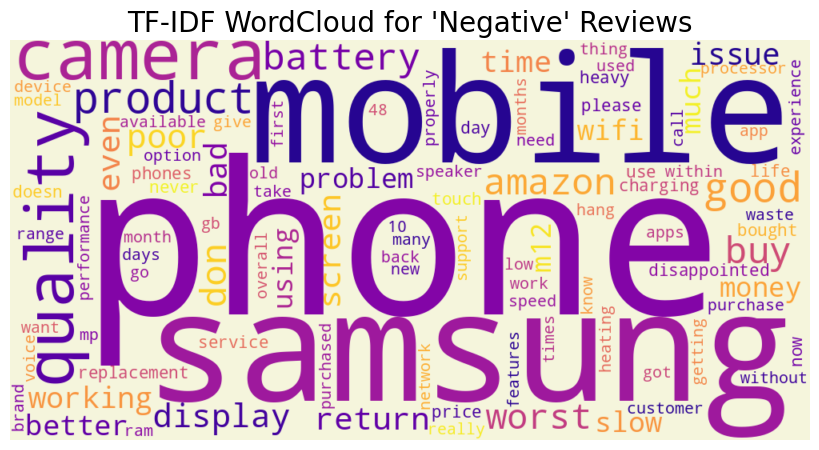

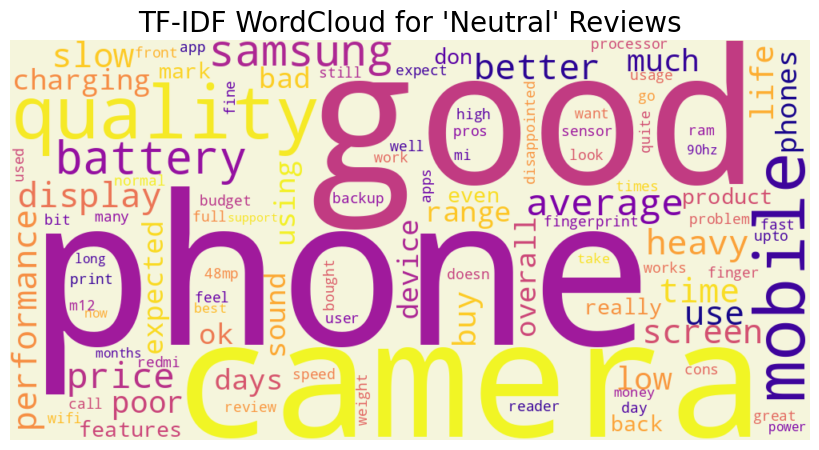

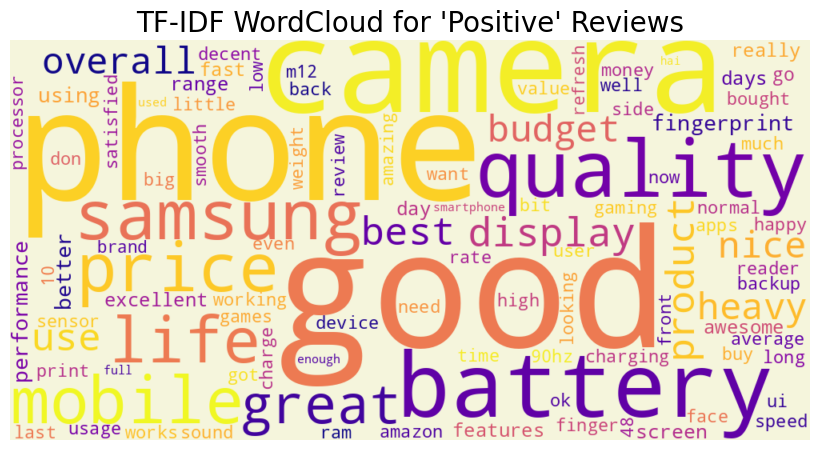

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Drop missing values to avoid issues
df = df.dropna(subset=['body', 'sentiment'])

# Custom stopwords (add your own as needed)
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'will', 'one', 'also'])  # Optional additions

# Convert to list for TfidfVectorizer
custom_stopwords = list(custom_stopwords)

# Loop through each sentiment and generate TF-IDF word cloud
for sentiment in sorted(df['sentiment'].unique()):
    subset = df[df['sentiment'] == sentiment]['body'].astype(str)

    # Initialize and fit TF-IDF Vectorizer
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=100)
    tfidf_matrix = vectorizer.fit_transform(subset)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1  # Convert sparse matrix to array

    # Create dictionary of word: tfidf_score
    tfidf_dict = dict(zip(feature_names, tfidf_scores))

    # Generate WordCloud from TF-IDF scores
    wc = WordCloud(width=1000, height=500, background_color='beige', max_words=100, colormap='plasma', contour_color='steelblue',
                   contour_width=1).generate_from_frequencies(tfidf_dict)

    # Plot
    plt.figure(figsize=(8, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"TF-IDF WordCloud for '{sentiment.capitalize()}' Reviews", fontsize=20)
    plt.tight_layout(pad=0)
    plt.show()


### **Compare Top TF-IDF Words Across Sentiments (Side-by-Side Table)**

This helps validate the word clouds and gives exact weights.

* **Use case**: Helps compare what words are *actually meaningful* to each sentiment.

* This lets you **compare TF-IDF keywords across sentiments**:

---

In [ ]:
# Initialize container
tfidf_by_sentiment = {}

# Loop through sentiments
for sentiment in sorted(df['sentiment'].unique()):
    subset = df[df['sentiment'] == sentiment]['body'].astype(str)
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=10)
    tfidf_matrix = vectorizer.fit_transform(subset)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    top_words = pd.Series(tfidf_scores, index=feature_names).sort_values(ascending=False)
    tfidf_by_sentiment[sentiment] = top_words

# Combine and display
tfidf_df = pd.DataFrame(tfidf_by_sentiment).fillna(0)
print("\nTop TF-IDF Words by Sentiment:\n")
print(tfidf_df)



Top TF-IDF Words by Sentiment:

           Negative    Neutral    Positive
amazon    54.998031   0.000000    0.000000
average    0.000000  18.912553    0.000000
battery   61.301427  32.939129  150.057556
better     0.000000  18.098801    0.000000
buy       56.796483   0.000000    0.000000
camera    79.048128  39.240412  156.593558
display    0.000000   0.000000   65.380145
good      56.891434  49.521167  220.396650
life       0.000000   0.000000   85.819522
mobile    86.720967  26.849620   78.148127
phone    160.557342  57.347400  214.694614
price      0.000000  18.845330   96.216094
product   68.991214   0.000000    0.000000
quality   67.686924  33.721852  111.041186
samsung   98.680213  28.839775  101.610887


In [ ]:
# Plotting this only for Positive

import plotly.express as px
import pandas as pd

# Get top TF-IDF words for Positive sentiment
positive_words = tfidf_by_sentiment['Positive']

# Convert to DataFrame
positive_df = pd.DataFrame({'word': positive_words.index, 'tfidf': positive_words.values})

# Plot Treemap
fig = px.treemap(positive_df, path=['word'], values='tfidf', title="TF-IDF Treemap for 'Positive' Reviews", color='tfidf', color_continuous_scale='Hot') #'Blues','Tealgrn'

# Set plot size
fig.update_layout(
    width=800,   # Change width
    height=500,  # Change height
    title_font_size=24
)

fig.show()

In [ ]:
# @title TF-IDF Treemap for All 3 Reviews
# Loop through each sentiment and plot individual treemaps
for sentiment in tfidf_by_sentiment:
    top_words = tfidf_by_sentiment[sentiment]

    # Convert to DataFrame
    temp_df = pd.DataFrame({'word': top_words.index, 'tfidf': top_words.values})

    # Plot Treemap
    fig = px.treemap(
        temp_df,
        path=['word'],  # Only word, since sentiment is constant
        values='tfidf',
        title=f"TF-IDF Treemap for '{sentiment.capitalize()}' Reviews",
        color='tfidf',
        color_continuous_scale='Blues'
    )

    # Set plot size
    fig.update_layout(width=800, height=500, title_font_size=24)

    fig.show()


---

## C) TF-IDF WordClouds by **Rating Level** (e.g., 1 to 5 stars)

This is just like what we did for sentiment — but now grouped by the `rating` column.

---

In [ ]:
# @title 🔧 TF-IDF WordClouds per Rating (1 to 5)
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd

# Clean and ensure correct types
df = df.dropna(subset=['body', 'rating'])
df['rating'] = df['rating'].astype(int)

# Custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'will', 'one', 'also'])
custom_stopwords = list(custom_stopwords)  # Convert to list for vectorizer

# Dictionary to store wordclouds for subplot use later
wordclouds_by_rating = {}

# Loop through rating levels (1 to 5)
for rating in sorted(df['rating'].unique()):
    subset = df[df['rating'] == rating]['body'].astype(str)

    # Initialize TF-IDF
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=100)
    tfidf_matrix = vectorizer.fit_transform(subset)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1
    tfidf_dict = dict(zip(feature_names, tfidf_scores))

    # Generate WordCloud
    wc = WordCloud(width=1000, height=500, background_color='beige', max_words=100, colormap='viridis', contour_color='steelblue',
                   contour_width=1).generate_from_frequencies(tfidf_dict)

    # Store in dict for subplot display
    wordclouds_by_rating[rating] = wc

---

### **Display All Rating WordClouds in a Single Grid**

We’ll arrange them in a **grid layout** using `matplotlib` subplots.

---

### 🖼️ Display All WordClouds (1–5 Ratings) in Grid

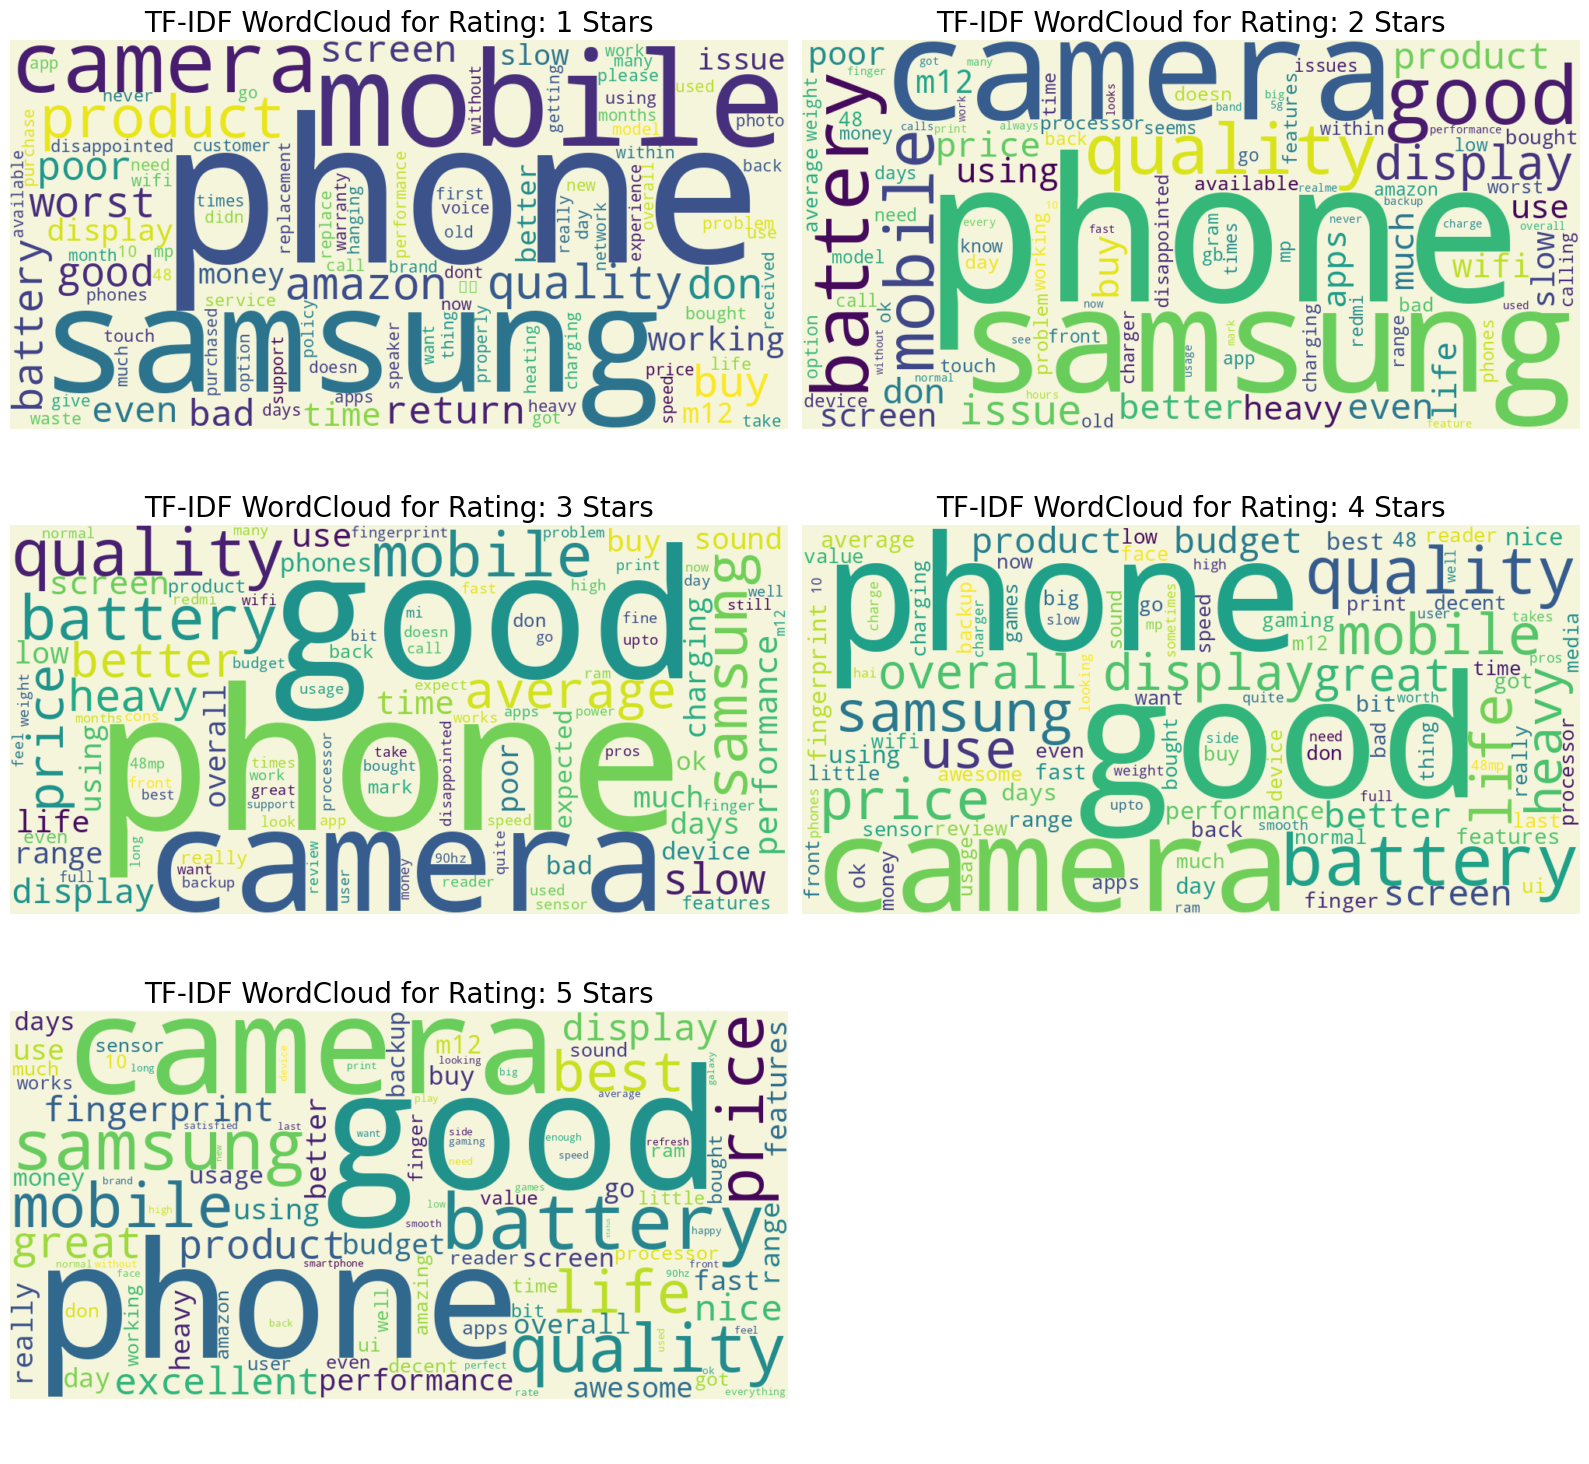

In [ ]:
# Determine grid layout (e.g., 5 columns for 5 ratings)
num_ratings = len(wordclouds_by_rating)
cols = 2
rows = (num_ratings + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, rows * 5))

# Flatten axes in case of single row
axes = axes.flatten()

# Loop and plot each WordCloud
for idx, (rating, wc) in enumerate(sorted(wordclouds_by_rating.items())):
    axes[idx].imshow(wc, interpolation='bilinear')
    axes[idx].axis("off")
    axes[idx].set_title(f"TF-IDF WordCloud for Rating: {rating} Stars", fontsize=20)

# Turn off unused axes
for j in range(idx + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
from wordcloud import STOPWORDS

# Define stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['said', 'will', 'one', 'also'])  # Optional additions
custom_stopwords = list(custom_stopwords)

# Clean and ensure types
df = df.dropna(subset=['body', 'rating'])
df['rating'] = df['rating'].astype(int)

# Container to store top words per rating
tfidf_by_rating = {}

# Loop through each rating level
for rating in sorted(df['rating'].unique()):
    subset = df[df['rating'] == rating]['body'].astype(str)

    # Vectorize with TF-IDF
    vectorizer = TfidfVectorizer(stop_words=custom_stopwords, max_features=50)
    tfidf_matrix = vectorizer.fit_transform(subset)
    feature_names = vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0).A1

    # Get top N words by TF-IDF score
    top_n = 10
    top_words = pd.Series(tfidf_scores, index=feature_names).sort_values(ascending=False).head(top_n)

    # Store just words (or scores if you prefer)
    tfidf_by_rating[f"{rating}-Star"] = top_words.index.tolist()

# Combine into DataFrame
tfidf_table = pd.DataFrame(tfidf_by_rating)
print("\n🔍 Top TF-IDF Words by Rating:\n")
print(tfidf_table)



🔍 Top TF-IDF Words by Rating:

    1-Star   2-Star   3-Star   4-Star   5-Star
0    phone    phone    phone     good     good
1  samsung  samsung     good    phone    phone
2   mobile   camera   camera   camera   camera
3   camera     good  quality  battery  battery
4  product  battery  battery  quality  quality
5  quality   mobile   mobile  samsung  samsung
6   amazon  quality  samsung   mobile    price
7      buy  display  average    price   mobile
8      don    issue    price     life     life
9    worst  product   better      use     best


---
# **Text cleaning**
1. Remove unwanted characters
2. Text normalization
3. Tokenization
4. lemmatization
5. Join the text

In [ ]:
df.head()

In [ ]:
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Download required NLTK resources (only once)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet')              # In case not already downloaded
nltk.download('omw-1.4', quiet=True)  # Required for lemmatizer to work fully
nltk.download('punkt', quiet=True)  # For tokenization

# Initialize preprocessing tools
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function for cleaning text
def preprocess_text(text):
    """
    Comprehensive text preprocessing function
    """
    # Handle missing/null values
    if pd.isna(text) or text == '':
        return ''

    # Convert to string (safety check)
    text = str(text)

    # Remove URLs, email addresses, and mentions (optional enhancement)
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)

    # Remove extra whitespace and newlines
    text = re.sub(r'\s+', ' ', text.strip())

    # Remove non-alphabetical characters
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Convert to lowercase, Text normalization
    text = text.lower()

    # Tokenize by splitting on whitespace
    words = text.split()

    # Remove stopwords, lemmatize, and filter short words
    words = [lemmatizer.lemmatize(word) for word in words
             if word not in stop_words and len(word) > 2]

    return ' '.join(words)  # Join sentences


# Convert body to string (important before text cleaning) & apply preprocessing
df['body'] = df['body'].astype(str)
df['clean_body'] = df['body'].apply(preprocess_text)    # Apply cleaning to all rows

# Optional: Add text statistics for analysis
df['original_length'] = df['body'].str.len()
df['clean_length'] = df['clean_body'].str.len()
df['word_count'] = df['clean_body'].str.split().str.len()

# Remove empty texts after preprocessing (optional)
df = df[df['clean_body'].str.len() > 0].reset_index(drop=True)

# Display preprocessing results
print("\nPreprocessing completed!")
print(f"Dataset shape: {df.shape}")
print(f"\nAverage word count after cleaning: {df['word_count'].mean():.2f}")

# Preview some examples
print("\nSample processed texts:")
for i in range(min(3, len(df))):
    print(f"\nOriginal: {df['body'].iloc[i][:100]}...")
    print(f"Cleaned:  {df['clean_body'].iloc[i][:100]}...")
    print(f"Sentiment: {df['sentiment'].iloc[i]}")

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!



Preprocessing completed!
Dataset shape: (1436, 10)

Average word count after cleaning: 28.95

Sample processed texts:

Original: Very disappointed with the overall performance from Samsung...
Cleaned:  disappointed overall performance samsung...
Sentiment: Negative

Original: Camera quality is low...
Cleaned:  camera quality low...
Sentiment: Neutral

Original: Got the mobile on the launch date,Battery must be appreciatedCamera is just averageMobile performanc...
Cleaned:  got mobile launch date battery must appreciatedcamera averagemobile performance average refresh rate...
Sentiment: Positive


In [ ]:
df.head()

,title,rating,body,sentiment,review_length,length_category,clean_body,original_length,clean_length,word_count
0,Horrible product,1,Very disappointed with the overall performance...,Negative,59,Short,disappointed overall performance samsung,59,40,4
1,Camera quality is not like 48 megapixel,3,Camera quality is low,Neutral,21,Short,camera quality low,21,18,3
2,Overall,4,"Got the mobile on the launch date,Battery must...",Positive,403,Long,got mobile launch date battery must appreciate...,403,257,34
3,A big no from me,1,1. It doesn't work with 5.0GHz WiFi frequency....,Negative,377,Long,work ghz wifi frequency ghz old school camera ...,377,194,31
4,Put your money somewhere else,1,"Not worth buying....faulty software, poor disp...",Negative,179,Medium,worth buying faulty software poor display qual...,179,135,22


> 🔁 The `astype(str)` makes sure any `NaN` or numbers don't break your preprocessing code.

Now that our text is cleaned (in `df['clean_body']`), the next step is to **convert the text into numerical features** so ML models can understand it.

* This process is called **vectorization**.

---

### (next step) Vectorization 🔢

##### Common methods:

1. **Bag of Words (CountVectorizer)** – counts word occurrences
2. **TF-IDF (TfidfVectorizer)** – weights word counts by importance
3. **Word Embeddings (e.g. Word2Vec, BERT)** – more advanced

We'll use **TF-IDF**, which is more robust than simple word counts.

---
## **Task 2:** 💡 Model Implementations :

### Apply Preprocessed Corpus to a Model Pipeline (Text Classification Example)

Let’s assume you want to **predict sentiment or rating** using the `body` column. Here’s a simple pipeline using **TF-IDF + Logistic Regression**.

---

#### ✅ Full Example: Build a Model Pipeline (TF-IDF + ML) ↴

Just simple Logistic regression :

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Ensure body is string
df['body'] = df['body'].astype(str)
df = df[df['clean_body'] != '']  # Remove empty rows if any

# Step 2: Use cleaned corpus from earlier
# (Reusing `corpus` from the preprocessing step)
# Prepare features and labels, Split
X = df['clean_body']
y = df['sentiment']  # Or df['rating'] if you're predicting that

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Create pipeline (TF-IDF + Logistic Regression)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=1500, stop_words='english')),     # You can tune max_features
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])

# Step 4: Train model & Evaluate
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

print("Logistic Regression Results:")
print("Classification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Logistic Regression Results:
Classification Report:
               precision    recall  f1-score   support

    Negative       0.75      0.81      0.78       102
     Neutral       0.30      0.28      0.29        40
    Positive       0.82      0.79      0.80       146

    accuracy                           0.73       288
   macro avg       0.62      0.63      0.62       288
weighted avg       0.72      0.73      0.72       288


Confusion Matrix:
 [[ 83   9  10]
 [ 13  11  16]
 [ 14  17 115]]


## **Hyper-Parameter tuned LR :**

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define pipeline again for GridSearch
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english')),
    ('clf', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

# Parameter grid
param_grid = {
    'tfidf__max_features': [1000, 1500, 2000],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.01, 0.05, 0.1, 1, 10],  # Regularization strength
    'clf__solver': ['liblinear', 'saga']
}

# Grid search
grid = GridSearchCV(pipeline, param_grid, scoring='f1_macro', cv=5, verbose=2, n_jobs=-1)
grid.fit(X_train, y_train)

# Best result
print("Best Parameters:", grid.best_params_)
print("Best F1 Score:", grid.best_score_)

# Evaluate on test data
y_pred = grid.predict(X_test)
print("Tuned Logistic Regression Results:")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'clf__C': 1, 'clf__solver': 'saga', 'tfidf__max_features': 1500, 'tfidf__ngram_range': (1, 2)}
Best F1 Score: 0.6338725767056419
Tuned Logistic Regression Results:
              precision    recall  f1-score   support

    Negative       0.75      0.80      0.78       102
     Neutral       0.28      0.28      0.28        40
    Positive       0.81      0.77      0.79       146

    accuracy                           0.71       288
   macro avg       0.61      0.62      0.61       288
weighted avg       0.71      0.71      0.71       288

[[ 82   9  11]
 [ 13  11  16]
 [ 14  20 112]]


Starting Feature Extraction and Model Building...

FEATURE EXTRACTION
1. Creating TF-IDF features...
2. Creating Count (BoW) features...

Data Split:
Training set: 1148 samples
Test set: 288 samples

MODEL BUILDING AND EVALUATION

--- Testing with TF-IDF Features ---
Training Logistic Regression...
  Accuracy: 0.6979
  CV Score: 0.7326 (+/- 0.0334)

BEST MODEL SELECTION
Best Model: Logistic Regression with TF-IDF
Best Accuracy: 0.6979
Best CV Score: 0.7326

DETAILED EVALUATION - BEST MODEL
Classification Report:
              precision    recall  f1-score   support

    Negative       0.75      0.75      0.75       102
     Neutral       0.25      0.30      0.27        40
    Positive       0.81      0.77      0.79       146

    accuracy                           0.70       288
   macro avg       0.61      0.61      0.60       288
weighted avg       0.71      0.70      0.71       288



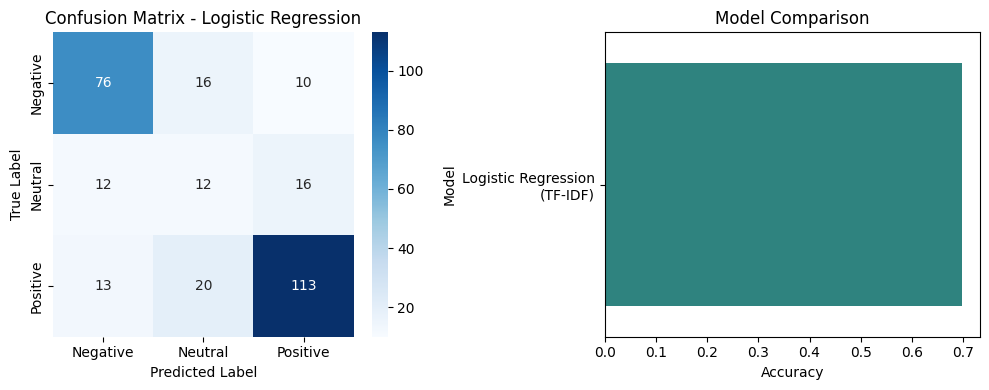


HYPERPARAMETER TUNING
Tuning hyperparameters for Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 1, 'solver': 'saga'}
Best CV score: 0.6321
Final tuned model accuracy: 0.6979

SAVING THE BEST MODEL
Model saved as: sentiment_analysis_model.pkl
Best configuration: Logistic Regression with TF-IDF vectorization
Final accuracy: 0.6979

TESTING PREDICTION FUNCTION

Text: 'This product is amazing! I love it so much.'
Predicted Sentiment: Positive
Confidence: 0.7010
All Probabilities: {'Negative': np.float64(0.2190580272891161), 'Neutral': np.float64(0.07996362853871797), 'Positive': np.float64(0.700978344172166)}

Text: 'This is the worst thing I've ever bought.'
Predicted Sentiment: Negative
Confidence: 0.8035
All Probabilities: {'Negative': np.float64(0.8034537740099671), 'Neutral': np.float64(0.07109921801403996), 'Positive': np.float64(0.12544700797599287)}

Text: 'It's okay, nothing special but not bad either.'
Predicted Sentime

In [ ]:
# @title **Complete One short Pipeline**
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer  #(BoW)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings('ignore')

# Assuming df is already preprocessed with 'clean_body' and 'sentiment' columns
print("Starting Feature Extraction and Model Building...")

# ===== FEATURE EXTRACTION =====

print("\n" + "="*50)
print("FEATURE EXTRACTION")
print("="*50)

# 1. TF-IDF Features
print("1. Creating TF-IDF features...")
tfidf_vectorizer = TfidfVectorizer(
    max_features=1500,        # Limit vocabulary size (can use 1500)  # we can also tune max_features
    min_df=2,                 # Ignore terms that appear in less than 2 documents
    max_df=0.95,              # Ignore terms that appear in more than 95% of documents
    ngram_range=(1, 2),       # Use unigrams and bigrams
    stop_words='english'      # Additional stopword removal
)

# 2. Count Features (Bag of Words)
print("2. Creating Count (BoW) features...")
count_vectorizer = CountVectorizer(max_features=1500, min_df=2, max_df=0.95, ngram_range=(1, 2), stop_words='english')

# ===== DATA SPLITTING =====
X = df['clean_body']      # (Reusing `corpus` from the preprocessing step)
y = df['sentiment']       # Or df['rating'] if you're predicting that

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nData Split:")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# ===== MODEL BUILDING =====

print("\n" + "="*50)
print("MODEL BUILDING AND EVALUATION")
print("="*50)

# Define models to test
models = {
    #'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
    #'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    #'SVM': SVC(random_state=42, probability=True)
}

# Define vectorizers
vectorizers = {
    'TF-IDF': tfidf_vectorizer,
    #'Count': count_vectorizer
}

# Store results
results = {}
best_models = {}

# Test each combination
for vec_name, vectorizer in vectorizers.items():
    print(f"\n--- Testing with {vec_name} Features ---")

    # Fit vectorizer and transform data
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)

    results[vec_name] = {}

    for model_name, model in models.items():
        print(f"Training {model_name}...")

        # Train model
        model.fit(X_train_vec, y_train)

        # Make predictions
        y_pred = model.predict(X_test_vec)

        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)

        # Cross-validation score
        cv_scores = cross_val_score(model, X_train_vec, y_train, cv=5)

        # Store results
        results[vec_name][model_name] = {
            'accuracy': accuracy,
            'cv_mean': cv_scores.mean(),
            'cv_std': cv_scores.std(),
            'model': model,
            'vectorizer': vectorizer,
            'predictions': y_pred
        }

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std()*2:.4f})")

# ===== FIND BEST MODEL =====

print("\n" + "="*50)
print("BEST MODEL SELECTION")
print("="*50)

best_accuracy = 0
best_config = None

for vec_name in results:
    for model_name in results[vec_name]:
        acc = results[vec_name][model_name]['accuracy']
        if acc > best_accuracy:
            best_accuracy = acc
            best_config = (vec_name, model_name)

best_vec, best_model_name = best_config
best_model_info = results[best_vec][best_model_name]

print(f"Best Model: {best_model_name} with {best_vec}")
print(f"Best Accuracy: {best_accuracy:.4f}")
print(f"Best CV Score: {best_model_info['cv_mean']:.4f}")

# ===== DETAILED EVALUATION OF BEST MODEL =====

print("\n" + "="*50)
print("DETAILED EVALUATION - BEST MODEL")
print("="*50)

best_predictions = best_model_info['predictions']

# Classification Report
print("Classification Report:")
print(classification_report(y_test, best_predictions))

# Confusion Matrix
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Model Comparison
plt.subplot(1, 2, 2)
comparison_data = []
for vec_name in results:
    for model_name in results[vec_name]:
        comparison_data.append({
            'Model': f"{model_name}\n({vec_name})",
            'Accuracy': results[vec_name][model_name]['accuracy']
        })

comparison_df = pd.DataFrame(comparison_data)
sns.barplot(data=comparison_df, x='Accuracy', y='Model', palette='viridis')
plt.title('Model Comparison')
plt.xlabel('Accuracy')

plt.tight_layout()
plt.show()

# ===== HYPERPARAMETER TUNING FOR BEST MODEL =====

print("\n" + "="*50)
print("HYPERPARAMETER TUNING")
print("="*50)

# Get the best vectorizer and model
best_vectorizer = vectorizers[best_vec]
X_train_best = best_vectorizer.fit_transform(X_train)
X_test_best = best_vectorizer.transform(X_test)

# Define parameter grids for each model
param_grids = {
    'Naive Bayes': {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    },
    'Logistic Regression': {
        'C': [0.1, 1, 10, 100],
        'solver': ['liblinear', 'lbfgs', 'saga']
    },
    'Random Forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [10, 20, None]
    },
    'SVM': {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf']
    }
}

if best_model_name in param_grids:
    print(f"Tuning hyperparameters for {best_model_name}...")

    grid_search = GridSearchCV(
        models[best_model_name],
        param_grids[best_model_name],
        cv=5,
        scoring='f1_macro',
        verbose=2,
        n_jobs=-1
    )

    grid_search.fit(X_train_best, y_train)

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

    # Final model with best parameters
    final_model = grid_search.best_estimator_
    final_predictions = final_model.predict(X_test_best)
    final_accuracy = accuracy_score(y_test, final_predictions)

    print(f"Final tuned model accuracy: {final_accuracy:.4f}")
else:
    final_model = best_model_info['model']
    final_accuracy = best_accuracy

# ===== SAVE THE BEST MODEL =====

print("\n" + "="*50)
print("SAVING THE BEST MODEL")
print("="*50)

# Create a pipeline with the best vectorizer and model
final_pipeline = Pipeline([
    ('vectorizer', best_vectorizer),
    ('classifier', final_model)
])

# Fit the pipeline on full training data
final_pipeline.fit(X_train, y_train)

# Save the model
model_filename = 'sentiment_analysis_model.pkl'
joblib.dump(final_pipeline, model_filename)

print(f"Model saved as: {model_filename}")
print(f"Best configuration: {best_model_name} with {best_vec} vectorization")
print(f"Final accuracy: {final_accuracy:.4f}")

# ===== PREDICTION FUNCTION =====

def predict_sentiment(text, model_pipeline):
    """
    Function to predict sentiment of new text
    """
    # The pipeline will handle vectorization automatically
    prediction = model_pipeline.predict([text])[0]
    probability = model_pipeline.predict_proba([text])[0]

    # Get probability for predicted class
    classes = model_pipeline.classes_
    pred_prob = max(probability)

    return {
        'sentiment': prediction,
        'confidence': pred_prob,
        'probabilities': dict(zip(classes, probability))
    }

# Test the prediction function
print("\n" + "="*50)
print("TESTING PREDICTION FUNCTION")
print("="*50)

test_texts = [
    "This product is amazing! I love it so much.",
    "This is the worst thing I've ever bought.",
    "It's okay, nothing special but not bad either."
]

for text in test_texts:
    result = predict_sentiment(text, final_pipeline)
    print(f"\nText: '{text}'")
    print(f"Predicted Sentiment: {result['sentiment']}")
    print(f"Confidence: {result['confidence']:.4f}")
    print(f"All Probabilities: {result['probabilities']}")

print(f"\n{'='*50}")
print("MODEL BUILDING COMPLETED!")
print(f"{'='*50}")


# **🎭 Interactive Streamlit Sentiment Analysis Dashboard :**

In [ ]:
! pip install streamlit

In [ ]:
!pip install streamlit-lottie

In [ ]:
# @title Complete code block for app.py file
import streamlit as st
import joblib
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import time
from datetime import datetime
import base64
from io import BytesIO
from streamlit_lottie import st_lottie
import requests

# Download NLTK data (with error handling for deployment)
@st.cache_resource
def download_nltk_data():
    try:
        nltk.download('stopwords', quiet=True)
        nltk.download('wordnet', quiet=True)
        nltk.download('omw-1.4', quiet=True)
        return True
    except:
        return False

# Add this function after your other @st.cache_resource functions
@st.cache_resource
def load_lottie_url(url: str):
    """Load Lottie animation from URL"""
    try:
        r = requests.get(url)
        if r.status_code != 200:
            return None
        return r.json()
    except:
        return None

@st.cache_resource
def load_header_animation():
    """Load header animation"""
    # Data analysis animation URL
    animation_url = 'https://assets2.lottiefiles.com/packages/lf20_qp1q7mct.json'
    return load_lottie_url(animation_url)

# Load the header animation
header_animation = load_header_animation()

# Initialize NLTK
download_nltk_data()

# Page config
st.set_page_config(
    page_title="🎭 Sentiment Analysis AI",
    page_icon="🎭",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS for beautiful styling
st.markdown("""
<style>
    .main-header {
        font-size: 3rem;
        font-weight: bold;
        text-align: center;
        background: linear-gradient(90deg, #667eea 0%, #764ba2 100%);
        -webkit-background-clip: text;
        -webkit-text-fill-color: transparent;
        margin-bottom: 2rem;
    }

    .sentiment-positive {
        background: linear-gradient(45deg, #56ab2f, #a8e6cf);
        padding: 1rem;
        border-radius: 10px;
        text-align: center;
        color: white;
        font-weight: bold;
        margin: 0.5rem 0;
    }

    .sentiment-negative {
        background: linear-gradient(45deg, #cb2d3e, #ef473a);
        padding: 1rem;
        border-radius: 10px;
        text-align: center;
        color: white;
        font-weight: bold;
        margin: 0.5rem 0;
    }

    .sentiment-neutral {
        background: linear-gradient(45deg, #bdc3c7, #2c3e50);
        padding: 1rem;
        border-radius: 10px;
        text-align: center;
        color: white;
        font-weight: bold;
        margin: 0.5rem 0;
    }

    .metric-card {
        background: white;
        padding: 1rem;
        border-radius: 10px;
        box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        text-align: center;
    }

    .stTextArea textarea {
        border-radius: 10px;
        border: 2px solid #667eea;
    }
</style>
""", unsafe_allow_html=True)

# Load model with caching
@st.cache_resource
def load_model():
    try:
        model = joblib.load('sentiment_analysis_model.pkl')
        return model
    except FileNotFoundError:
        st.error("❌ Model file not found! Please make sure 'sentiment_analysis_model.pkl' is in the app directory.")
        return None

# Preprocessing function (same as training)
@st.cache_resource
def init_preprocessing_tools():
    try:
        lemmatizer = WordNetLemmatizer()
        stop_words = set(stopwords.words('english'))
        return lemmatizer, stop_words
    except:
        # Fallback if NLTK data not available
        return None, set()

lemmatizer, stop_words = init_preprocessing_tools()

def preprocess_text(text):
    """Preprocess text exactly as done during training"""
    if pd.isna(text) or text == '':
        return ''

    text = str(text)
    text = re.sub(r'http\S+|www\S+|@\S+', '', text)
    text = re.sub(r'\s+', ' ', text.strip())
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    text = text.lower()
    words = text.split()

    if lemmatizer and stop_words:
        words = [lemmatizer.lemmatize(word) for word in words
                 if word not in stop_words and len(word) > 2]
    else:
        words = [word for word in words if len(word) > 2]

    return ' '.join(words)

def predict_sentiment(text, model):
    """Predict sentiment with preprocessing"""
    if not model:
        return None

    # Preprocess the text
    cleaned_text = preprocess_text(text)

    if not cleaned_text:
        return {
            'sentiment': 'Neutral',
            'confidence': 0.33,
            'probabilities': {'Positive': 0.33, 'Neutral': 0.34, 'Negative': 0.33}
        }

    try:
        prediction = model.predict([cleaned_text])[0]
        probabilities = model.predict_proba([cleaned_text])[0]
        classes = model.classes_
        confidence = max(probabilities)

        return {
            'sentiment': prediction,
            'confidence': confidence,
            'probabilities': dict(zip(classes, probabilities)),
            'cleaned_text': cleaned_text
        }
    except Exception as e:
        st.error(f"Prediction error: {str(e)}")
        return None

def get_sentiment_emoji(sentiment):
    """Get emoji for sentiment"""
    emoji_map = {
        'Positive': '😊',
        'Negative': '😞',
        'Neutral': '😐'
    }
    return emoji_map.get(sentiment, '🤔')

def get_sentiment_color(sentiment):
    """Get color for sentiment"""
    color_map = {
        'Positive': '#56ab2f',
        'Negative': '#cb2d3e',
        'Neutral': '#bdc3c7'
    }
    return color_map.get(sentiment, '#gray')

# Initialize session state
if 'history' not in st.session_state:
    st.session_state.history = []

# Load the model
model = load_model()

# Main header
# Enhanced header with animation
col_anim, col_title, col_spacer = st.columns([1, 4, 1])

with col_anim:
    if header_animation:
        st_lottie(
            header_animation,
            height=120,
            width=120,
            key="header_animation",
            speed=1
        )
    else:
        st.markdown('<div style="font-size: 4rem; text-align: center;">📊</div>', unsafe_allow_html=True)

with col_title:
    st.markdown('<h1 class="main-header">🎭 AI Sentiment Analysis Dashboard</h1>', unsafe_allow_html=True)
    st.markdown('<p style="text-align: center; font-size: 1.2rem; color: #666;">Powered by Advanced NLP & Machine Learning</p>', unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.markdown("## 🚀 App Features")
    st.markdown("""
    - **Real-time Analysis**: Instant sentiment detection
    - **Confidence Scores**: Probability breakdown
    - **History Tracking**: View past predictions
    - **Batch Processing**: Analyze multiple texts
    - **Interactive Charts**: Beautiful visualizations
    """)

    st.markdown("---")
    st.markdown("## 📊 Model Info")
    if model:
        st.success("✅ Model Loaded Successfully")
        st.info("🤖 Algorithm: Optimized ML Pipeline")
        st.info("📝 Features: TF-IDF + N-grams")
    else:
        st.error("❌ Model Not Available")

# Main content
tab1, tab2, tab3, tab4 = st.tabs(["🔍 Single Analysis", "📋 Batch Analysis", "📈 Analytics", "🕒 History"])

with tab1:
    st.markdown("### 💬 Analyze Your Text")

    # Text input methods
    input_method = st.radio("Choose input method:", ["✍️ Type Text", "📎 Upload File"], horizontal=True)

    if input_method == "✍️ Type Text":
        user_input = st.text_area(
            "Enter your text here:",
            placeholder="Type or paste your text here... (e.g., 'I love this product!', 'This service is terrible', etc.)",
            height=120
        )
    else:
        uploaded_file = st.file_uploader("Upload a text file", type=['txt'])
        if uploaded_file:
            user_input = str(uploaded_file.read(), "utf-8")
            st.text_area("File content:", user_input, height=120, disabled=True)
        else:
            user_input = ""

    if st.button("🔍 Analyze Sentiment", type="primary", use_container_width=True):
        if user_input and model:
            with st.spinner("🤖 Analyzing sentiment..."):
                time.sleep(0.5)  # Add small delay for effect
                result = predict_sentiment(user_input, model)

                if result:
                    sentiment = result['sentiment']
                    confidence = result['confidence']
                    probabilities = result['probabilities']

                    # Add to history
                    st.session_state.history.append({
                        'timestamp': datetime.now(),
                        'text': user_input[:100] + "..." if len(user_input) > 100 else user_input,
                        'sentiment': sentiment,
                        'confidence': confidence
                    })

                    # Display results
                    col1, col2, col3 = st.columns([2, 1, 2])

                    with col2:
                        emoji = get_sentiment_emoji(sentiment)
                        st.markdown(f"""
                        <div style="text-align: center; font-size: 4rem; margin: 1rem 0;">
                            {emoji}
                        </div>
                        """, unsafe_allow_html=True)

                    # Sentiment result with styling
                    sentiment_class = f"sentiment-{sentiment.lower()}"
                    st.markdown(f"""
                    <div class="{sentiment_class}">
                        <h2>{sentiment.upper()} SENTIMENT</h2>
                        <p>Confidence: {confidence:.1%}</p>
                    </div>
                    """, unsafe_allow_html=True)

                    # Probability breakdown
                    st.markdown("### 📊 Confidence Breakdown")

                    # Create probability chart
                    prob_df = pd.DataFrame(list(probabilities.items()), columns=['Sentiment', 'Probability'])

                    fig = px.bar(
                        prob_df,
                        x='Sentiment',
                        y='Probability',
                        color='Sentiment',
                        color_discrete_map={
                            'Positive': '#56ab2f',
                            'Negative': '#cb2d3e',
                            'Neutral': '#bdc3c7'
                        },
                        title="Sentiment Probability Distribution"
                    )
                    fig.update_layout(showlegend=False, height=400)
                    st.plotly_chart(fig, use_container_width=True)

                    # Text analysis insights
                    with st.expander("🔍 Text Analysis Insights"):
                        col1, col2, col3, col4 = st.columns(4)

                        with col1:
                            st.metric("Word Count", len(user_input.split()))
                        with col2:
                            st.metric("Character Count", len(user_input))
                        with col3:
                            # Simple polarity using TextBlob as additional insight
                            try:
                                polarity = TextBlob(user_input).sentiment.polarity
                                st.metric("Polarity", f"{polarity:.2f}")
                            except:
                                st.metric("Polarity", "N/A")
                        with col4:
                            st.metric("Cleaned Words", len(result.get('cleaned_text', '').split()))

                        st.markdown("**Preprocessed Text:**")
                        st.code(result.get('cleaned_text', 'N/A'))

        elif not user_input:
            st.warning("⚠️ Please enter some text to analyze!")
        else:
            st.error("❌ Model not available. Please check the model file.")

with tab2:
    st.markdown("### 📋 Batch Analysis")
    st.markdown("Analyze multiple texts at once")

    batch_input = st.text_area(
        "Enter multiple texts (one per line):",
        placeholder="This product is amazing!\nI hate this service.\nIt's okay, nothing special.",
        height=200
    )

    if st.button("🔍 Analyze All", type="primary"):
        if batch_input and model:
            texts = [text.strip() for text in batch_input.split('\n') if text.strip()]

            if texts:
                results = []
                progress_bar = st.progress(0)

                for i, text in enumerate(texts):
                    result = predict_sentiment(text, model)
                    if result:
                        results.append({
                            'Text': text[:50] + "..." if len(text) > 50 else text,
                            'Sentiment': result['sentiment'],
                            'Confidence': f"{result['confidence']:.1%}",
                            'Emoji': get_sentiment_emoji(result['sentiment'])
                        })
                    progress_bar.progress((i + 1) / len(texts))

                if results:
                    st.markdown("### 📊 Batch Results")
                    df = pd.DataFrame(results)
                    st.dataframe(df, use_container_width=True)

                    # Summary statistics
                    col1, col2, col3 = st.columns(3)

                    sentiment_counts = df['Sentiment'].value_counts()

                    with col1:
                        st.metric("Total Analyzed", len(results))
                    with col2:
                        st.metric("Most Common", sentiment_counts.index[0] if len(sentiment_counts) > 0 else "N/A")
                    with col3:
                        avg_conf = df['Confidence'].str.rstrip('%').astype(float).mean()
                        st.metric("Avg Confidence", f"{avg_conf:.1f}%")

                    # Batch visualization
                    fig = px.pie(
                        values=sentiment_counts.values,
                        names=sentiment_counts.index,
                        title="Sentiment Distribution",
                        color_discrete_map={
                            'Positive': '#56ab2f',
                            'Negative': '#cb2d3e',
                            'Neutral': '#bdc3c7'
                        }
                    )
                    st.plotly_chart(fig, use_container_width=True)

with tab3:
    st.markdown("### 📈 Analytics Dashboard")

    if st.session_state.history:
        hist_df = pd.DataFrame(st.session_state.history)

        # Overview metrics
        col1, col2, col3, col4 = st.columns(4)

        with col1:
            st.metric("Total Analyses", len(hist_df))
        with col2:
            avg_confidence = hist_df['confidence'].mean()
            st.metric("Avg Confidence", f"{avg_confidence:.1%}")
        with col3:
            most_common = hist_df['sentiment'].mode().iloc[0] if len(hist_df) > 0 else "N/A"
            st.metric("Most Common", most_common)
        with col4:
            high_conf = (hist_df['confidence'] > 0.8).sum()
            st.metric("High Confidence", f"{high_conf}/{len(hist_df)}")

        # Sentiment distribution over time
        hist_df['date'] = hist_df['timestamp'].dt.date
        daily_sentiment = hist_df.groupby(['date', 'sentiment']).size().reset_index(name='count')

        fig = px.bar(
            daily_sentiment,
            x='date',
            y='count',
            color='sentiment',
            title="Sentiment Analysis Over Time",
            color_discrete_map={
                'Positive': '#56ab2f',
                'Negative': '#cb2d3e',
                'Neutral': '#bdc3c7'
            }
        )
        st.plotly_chart(fig, use_container_width=True)

        # Confidence distribution
        fig2 = px.histogram(
            hist_df,
            x='confidence',
            nbins=20,
            title="Confidence Score Distribution",
            color_discrete_sequence=['#667eea']
        )
        st.plotly_chart(fig2, use_container_width=True)

    else:
        st.info("📊 No analysis history yet. Start analyzing some texts to see analytics!")

with tab4:
    st.markdown("### 🕒 Analysis History")

    if st.session_state.history:
        # Show recent analyses
        for i, item in enumerate(reversed(st.session_state.history[-10:])):  # Show last 10
            with st.container():
                col1, col2, col3 = st.columns([3, 1, 1])

                with col1:
                    st.markdown(f"**{item['text']}**")
                    st.caption(f"🕐 {item['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")

                with col2:
                    emoji = get_sentiment_emoji(item['sentiment'])
                    st.markdown(f"## {emoji}")
                    st.caption(item['sentiment'])

                with col3:
                    st.metric("Confidence", f"{item['confidence']:.1%}")

                st.divider()

        # Clear history button
        if st.button("🗑️ Clear History", type="secondary"):
            st.session_state.history = []
            st.rerun()
    else:
        st.info("📝 No analysis history yet. Start analyzing some texts!")

# Footer
st.markdown("---")
st.markdown("""
<div style="text-align: center; color: #666; padding: 2rem;">
    <p>🚀 Built with Streamlit • 🤖 Powered by Machine Learning • 💡 Made with ❤️</p>
</div>

""", unsafe_allow_html=True)


In [ ]:
# @title preprocessing_module.py file
"""
Text Preprocessing Module for Sentiment Analysis
Handles all text cleaning and preprocessing operations
"""

import re
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import logging

# Setup logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class TextPreprocessor:
    """
    A comprehensive text preprocessing class for sentiment analysis
    """

    def __init__(self, download_nltk=True):
        """
        Initialize the preprocessor

        Args:
            download_nltk (bool): Whether to download required NLTK data
        """
        self.lemmatizer = None
        self.stop_words = set()

        if download_nltk:
            self._download_nltk_requirements()

        self._initialize_tools()

    def _download_nltk_requirements(self):
        """Download required NLTK data"""
        try:
            nltk.download('stopwords', quiet=True)
            nltk.download('wordnet', quiet=True)
            nltk.download('omw-1.4', quiet=True)
            nltk.download('punkt', quiet=True)
            logger.info("NLTK data downloaded successfully")
        except Exception as e:
            logger.warning(f"Could not download NLTK data: {e}")

    def _initialize_tools(self):
        """Initialize preprocessing tools"""
        try:
            self.lemmatizer = WordNetLemmatizer()
            self.stop_words = set(stopwords.words('english'))
            logger.info("Preprocessing tools initialized successfully")
        except Exception as e:
            logger.warning(f"Could not initialize preprocessing tools: {e}")
            self.lemmatizer = None
            self.stop_words = set()

    def clean_text(self, text):
        """
        Clean and preprocess a single text

        Args:
            text (str): Input text to clean

        Returns:
            str: Cleaned text
        """
        # Handle missing/null values
        if pd.isna(text) or text == '':
            return ''

        # Convert to string (safety check)
        text = str(text)

        # Remove URLs, email addresses, and mentions
        text = re.sub(r'http\S+|www\S+|@\S+', '', text)

        # Remove extra whitespace and newlines
        text = re.sub(r'\s+', ' ', text.strip())

        # Remove non-alphabetical characters
        text = re.sub(r'[^a-zA-Z]', ' ', text)

        # Convert to lowercase
        text = text.lower()

        # Tokenize by splitting on whitespace
        words = text.split()

        # Remove stopwords, lemmatize, and filter short words
        if self.lemmatizer and self.stop_words:
            words = [self.lemmatizer.lemmatize(word) for word in words
                     if word not in self.stop_words and len(word) > 2]
        else:
            # Fallback without lemmatization
            words = [word for word in words if len(word) > 2]

        return ' '.join(words)

    def preprocess_batch(self, texts):
        """
        Preprocess a batch of texts

        Args:
            texts (list): List of texts to preprocess

        Returns:
            list: List of cleaned texts
        """
        return [self.clean_text(text) for text in texts]

    def preprocess_dataframe(self, df, text_column, output_column=None):
        """
        Preprocess texts in a pandas DataFrame

        Args:
            df (pd.DataFrame): Input dataframe
            text_column (str): Name of column containing text
            output_column (str): Name of output column (default: text_column + '_clean')

        Returns:
            pd.DataFrame: DataFrame with cleaned text column
        """
        if output_column is None:
            output_column = f"{text_column}_clean"

        # Ensure text column is string type
        df[text_column] = df[text_column].astype(str)

        # Apply preprocessing
        df[output_column] = df[text_column].apply(self.clean_text)

        logger.info(f"Preprocessed {len(df)} texts in column '{text_column}'")

        return df

def rating_to_sentiment(rating):
    """
    Convert numerical rating to sentiment label

    Args:
        rating (int/float): Numerical rating

    Returns:
        str: Sentiment label (Positive, Negative, Neutral, Unknown)
    """
    if pd.isna(rating):
        return "Unknown"

    try:
        rating = float(rating)
        if rating in [1, 2]:
            return "Negative"
        elif rating == 3:
            return "Neutral"
        elif rating in [4, 5]:
            return "Positive"
        else:
            return "Unknown"
    except (ValueError, TypeError):
        return "Unknown"

def get_text_statistics(text):
    """
    Get basic statistics about a text

    Args:
        text (str): Input text

    Returns:
        dict: Dictionary with text statistics
    """
    if pd.isna(text) or text == '':
        return {
            'char_count': 0,
            'word_count': 0,
            'sentence_count': 0,
            'avg_word_length': 0
        }

    text = str(text)
    words = text.split()
    sentences = text.count('.') + text.count('!') + text.count('?')

    return {
        'char_count': len(text),
        'word_count': len(words),
        'sentence_count': max(1, sentences),  # At least 1 sentence
        'avg_word_length': sum(len(word) for word in words) / len(words) if words else 0
    }

# Example usage and testing
if __name__ == "__main__":
    # Initialize preprocessor
    preprocessor = TextPreprocessor()

    # Test texts
    test_texts = [
        "This product is absolutely AMAZING!!! I love it so much 😍",
        "This is the worst service I've ever experienced. Terrible!",
        "It's okay, nothing special but not bad either.",
        "Check out this link: https://example.com @user #hashtag"
    ]

    print("Testing Text Preprocessing:")
    print("=" * 50)

    for i, text in enumerate(test_texts, 1):
        cleaned = preprocessor.clean_text(text)
        stats = get_text_statistics(text)

        print(f"\nTest {i}:")
        print(f"Original:  {text}")
        print(f"Cleaned:   {cleaned}")
        print(f"Stats:     {stats}")

    # Test rating conversion
    print("\nTesting Rating to Sentiment Conversion:")
    print("=" * 50)

    test_ratings = [1, 2, 3, 4, 5, 2.5, None, "invalid"]
    for rating in test_ratings:
        sentiment = rating_to_sentiment(rating)
        print(f"Rating {rating} -> {sentiment}")

Testing Text Preprocessing:

Test 1:
Original:  This product is absolutely AMAZING!!! I love it so much 😍
Cleaned:   product absolutely amazing love much
Stats:     {'char_count': 57, 'word_count': 11, 'sentence_count': 3, 'avg_word_length': 4.2727272727272725}

Test 2:
Original:  This is the worst service I've ever experienced. Terrible!
Cleaned:   worst service ever experienced terrible
Stats:     {'char_count': 58, 'word_count': 9, 'sentence_count': 2, 'avg_word_length': 5.555555555555555}

Test 3:
Original:  It's okay, nothing special but not bad either.
Cleaned:   okay nothing special bad either
Stats:     {'char_count': 46, 'word_count': 8, 'sentence_count': 1, 'avg_word_length': 4.875}

Test 4:
Original:  Check out this link: https://example.com @user #hashtag
Cleaned:   check link hashtag
Stats:     {'char_count': 55, 'word_count': 7, 'sentence_count': 1, 'avg_word_length': 7.0}

Testing Rating to Sentiment Conversion:
Rating 1 -> Negative
Rating 2 -> Negative
Rating 3 -> Neutr